# Quickstart LSST Verify Demo

<br>Owner: **Keith Bechtol** ([@bechtol](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@bechtol))
<br>Last Verified to Run: **d_2019_02_04**
<br>Verified Stack Release: **d_2019_02_04**, **d_2019_01_15**, need to check v16.0

LSST Verify python pakcage: https://github.com/lsst/verify

This notebook is based on the documentation at https://sqr-019.lsst.io/

Another example: https://github.com/mareuter/notebooks/blob/master/LSST/Systems_Engineering/System_Verification_SQuaSH/System_Verification_Demo.ipynb

for which the metrics are defined here:
https://github.com/mareuter/notebooks/tree/master/LSST/Systems_Engineering/System_Verification_SQuaSH

## Setup

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

sciplat-lab-kbechtol-d20190204
lsst_distrib          16.0-3-g242c589+10 	current d_2019_02_04 setup


In [2]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import astropy.units as u

import lsst.verify

## Defining metrics and specifications

Rules for directory structure and naming

In [3]:
!tree verify_demo

verify_demo
├── metrics
│   ├── demo_astrometry.yaml
│   └── demo_photometry.yaml
└── specs
    ├── demo_astrometry
    │   └── specs.yaml
    └── demo_photometry
        └── specs.yaml

4 directories, 4 files


Let's take a look at the files

In [22]:
!cat verify_demo/metrics/demo_astrometry.yaml

AstrometricRMS:
  unit: mas
  description:
    Astrometric residual RMS.
  reference:
    url: https://example.com/AstroRMS
  tags:
    - astrometry
    - demo

In [23]:
!cat verify_demo/specs/demo_astrometry/specs.yaml

name: "minimum"
metric: "AstrometricRMS"
threshold:
  operator: "<="
  unit: "mas"
  value: 20.0
tags:
  - "minimum"
---
name: "design"
metric: "AstrometricRMS"
threshold:
  operator: "<="
  unit: "mas"
  value: 10.0
tags:
  - "design"

Note that the "---" between specifications is required

In [6]:
METRIC_PACKAGE = "verify_demo"
metrics = lsst.verify.MetricSet.load_metrics_package(METRIC_PACKAGE)
specs = lsst.verify.SpecificationSet.load_metrics_package(METRIC_PACKAGE)

In [7]:
metrics

Name,Description,Units,Reference,Tags
str30,str28,str15,str28,str16
demo_astrometry.AstrometricRMS,Astrometric residual RMS.,$\mathrm{mas}$,https://example.com/AstroRMS,"astrometry, demo"
demo_photometry.ZeropointRMS,Photometric calibration RMS.,$\mathrm{mmag}$,https://example.com/PhotRMS,"demo, photometry"


In [8]:
specs

Name,Test,Tags
str38,str27,str7
demo_astrometry.AstrometricRMS.design,$x$ <= 10.0 $\mathrm{mas}$,design
demo_astrometry.AstrometricRMS.minimum,$x$ <= 20.0 $\mathrm{mas}$,minimum
demo_photometry.ZeropointRMS.design,$x$ <= 10.0 $\mathrm{mmag}$,design
demo_photometry.ZeropointRMS.minimum,$x$ <= 20.0 $\mathrm{mmag}$,minimum


## Computing and storing metrics

These are completely made up values for purpose of illustration

In [9]:
zp_rms = 15.*u.mmag
zp_meas = lsst.verify.Measurement('demo_photometry.ZeropointRMS', zp_rms)

astro_rms = 15.*u.mas
astro_meas = lsst.verify.Measurement('demo_astrometry.AstrometricRMS', astro_rms)

It is possible to include extra information (again, completely made up values)

In [10]:
zp_meas.extras['x'] = lsst.verify.Datum(np.random.random(10) * u.mag, label="x", description="x-values")
zp_meas.extras['y'] = lsst.verify.Datum(np.random.random(10) * u.mag, label="y", description="y-values")

Create an LSST verify job and add the measurements

In [11]:
job = lsst.verify.Job.load_metrics_package()
job.metrics.update(metrics)
job.specs.update(specs)
job.measurements.insert(zp_meas)
job.measurements.insert(astro_meas)

Provide metadata

In [12]:
job.meta.update({'version': 'test'})

Write the output to a file

In [13]:
job.write('demo.json')

## Creating reports

Create a report. Read the file

In [14]:
with open('demo.json') as f:
    job = lsst.verify.Job.deserialize(**json.load(f))

In [15]:
job.report().show()

Status,Specification,Measurement,Test,Metric Tags,Spec. Tags
❌,demo_astrometry.AstrometricRMS.design,15.0 $\mathrm{mas}$,$x$ <= 10.0 $\mathrm{mas}$,"astrometry, demo",design
✅,demo_astrometry.AstrometricRMS.minimum,15.0 $\mathrm{mas}$,$x$ <= 20.0 $\mathrm{mas}$,"astrometry, demo",minimum
❌,demo_photometry.ZeropointRMS.design,15.0 $\mathrm{mmag}$,$x$ <= 10.0 $\mathrm{mmag}$,"demo, photometry",design
✅,demo_photometry.ZeropointRMS.minimum,15.0 $\mathrm{mmag}$,$x$ <= 20.0 $\mathrm{mmag}$,"demo, photometry",minimum


Select on particular tags

In [16]:
job.report(spec_tags=['minimum']).show()

Status,Specification,Measurement,Test,Metric Tags,Spec. Tags
✅,demo_astrometry.AstrometricRMS.minimum,15.0 $\mathrm{mas}$,$x$ <= 20.0 $\mathrm{mas}$,"astrometry, demo",minimum
✅,demo_photometry.ZeropointRMS.minimum,15.0 $\mathrm{mmag}$,$x$ <= 20.0 $\mathrm{mmag}$,"demo, photometry",minimum


In [17]:
#job.report(metric_tags=['demo']).show()
job.metrics['demo_astrometry.AstrometricRMS'].tags

{'astrometry', 'demo'}

In [18]:
#job.report(metric_tags=['minimum']).show()

In [19]:
job.meta

ChainMap({'version': 'test'}, {}, {})

In [20]:
m = job.measurements['demo_photometry.ZeropointRMS']

A lot of information is available for plotting 

(0, 1)

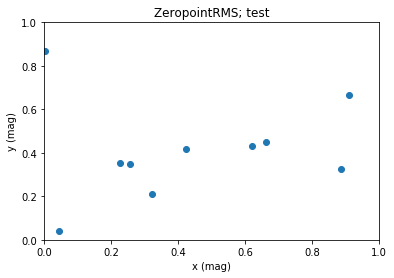

In [21]:
plt.figure()
plt.scatter(m.extras['x'].quantity, m.extras['y'].quantity)
plt.xlabel('%s (%s)'%(m.extras['x'].label, m.extras['x'].unit.name))
plt.ylabel('%s (%s)'%(m.extras['y'].label, m.extras['y'].unit.name))
plt.title('%s; %s'%(m.metric_name.metric, job.meta["version"]))
plt.xlim(0, 1)
plt.ylim(0, 1)